__MDP__: model knows the transition prob and reward values, compute and search through to find the optimal policy (y).


__RL__: model doesn't know the transition prob and reward, perform actions, sampling from the environment to learn the "approximated optimal policy" (y_hat) 

1. Come up with two interesting Markov Decision Processes (MDPs). For each MDP:<br>
a. Explain why it is interesting.<br>
b. Ensure one has a small number of states, and the other has a large number of states, with the large MDP not being a grid world problem.<br>

2. Solve each MDP using value iteration and policy iteration:<br>
a. Determine the number of iterations it takes for each to converge.<br>
b. Compare the speed of convergence between the two methods and explain why.<br>
c. Define the convergence criteria and determine if both methods converge to the same answer.<br>
d. Analyze the effect of the number of states on the convergence of the algorithms.<br>

3. Choose a reinforcement learning algorithm and use it to solve the two MDPs. For each MDP:<br>
a. Evaluate the performance of the algorithm.<br>
b. Compare the algorithm's performance to the value and policy iteration solutions.<br>
c. Choose and test exploration strategies and evaluate their effectiveness.<br>

# Set Env

In [3]:
import math
import gym
import pygame
from algorithms.rl import RL
from algorithms.planner import Planner
from examples.test_env import TestEnv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import LinearSegmentedColormap
from frozen_lake_modified import FrozenLakeEnv
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
from IPython.display import clear_output

# configuration
np.set_printoptions(suppress=True)
np.random.seed(2023)

# Define functions 

## Plot

In [93]:
class plots_frozen_lake:
    
    def policy_dict():
        return({3: '⬆',    2: '➡',    1: '⬇',    0: '⬅'})
    def env_dict():
        return({b'S': 0,    b'F': 1,    b'H': 2,    b'G': 3})
    def map_policy_to_sign(policy_matrix, policy_dict = policy_dict()):
        return(np.vectorize(policy_dict.get)(policy_matrix))
        
    
    def plot_grid_world_policy(env, policy, label = None,
                               policy_dict = policy_dict(), 
                               env_dict = env_dict()):
        import numpy as np
        import seaborn as sns
        import matplotlib.pyplot as plt

        size = env.desc.shape
        # Define the matrix
        grid_world = np.array(env.desc)
        
        if policy.shape != size:
            policy = np.array(policy).reshape(size) # matrix with 0-3 specifying action

        # Use the dictionary to map the values in the matrix
        data = np.vectorize(env_dict.get)(grid_world)

        # Define the color map
        cmap = ['grey', 'skyblue', 'black', 'green']
        # Plot the heatmap
        ax = sns.heatmap(data, annot=False, fmt='d', cmap=cmap, cbar=True)
        ax.set_title(label)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0.375, 1.125, 1.875, 2.625])
        colorbar.set_ticklabels(['Start', 'Frozen', 'Hole', 'Goal'])
        # Overlay policy
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] in [env_dict[b'F'],env_dict[b'S']]:
                    text = ax.text(j+0.5, i+0.5, policy_dict[policy[i,j]], weight='bold', size=10,
                           horizontalalignment='center', verticalalignment='center', color='w')

        plt.show()

    def grid_values_heat_map(env, value, label):
        size = env.desc.shape 
        if not math.modf(math.sqrt(len(value)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            data = np.around(np.array(value).reshape(size), 2)
            df = pd.DataFrame(data=data)
            sns.heatmap(df, annot=True).set_title(label)
            plt.show()

## Sovling MDP

In [5]:
def iter_gamma_on_MDP_iteration(env, algorithm = 'value',gamma_lower = 0.9, gamma_upper = 1, iter_by = 0.01):

    gamma_list = []
    time_used_list = []
    V_list = []
    pi_list = []
    new_pi_list = []
    n_iter_converged_list = []
    n_states = env.observation_space.n

    for g in np.round(np.arange(gamma_lower, gamma_upper+1e-10, iter_by),2).tolist():

        time_b = time.time()
        if algorithm == 'value':
            V, V_track, pi = Planner(env.P).value_iteration(gamma =g, n_iters = 10000)
        elif algorithm == 'policy':
            V, V_track, pi = Planner(env.P).policy_iteration(gamma =g, n_iters = 10000)
        else:
            print('please specify algorithm')
        time_used = time.time() - time_b
        #frozen lake
        if env.desc.shape[0]*env.desc.shape[1] == n_states: 
            new_pi = np.array(list(map(lambda x: pi(x), range(n_states)))).reshape(env.desc.shape)
        # taxi
        else: 
            new_pi = {i:pi(i) for i in range(n_states)}
        temp = [sum(V_track[i])!=0 for i in range(len(V_track))]
        n_iter_converged = (len(temp) - 1 - temp[::-1].index(True))+1

        gamma_list.append(g)
        time_used_list.append(round(time_used,4))
        V_list.append(V)
        pi_list.append(pi)
        new_pi_list.append(new_pi)
        n_iter_converged_list.append(n_iter_converged)

    return(
    {
       "gamma_list":gamma_list,
        "time_used_list":time_used_list,
        "V_list":V_list,
        "pi_list":pi_list,
        "new_pi_list":new_pi_list,
        "n_iter_converged_list":n_iter_converged_list
        
    }
    )
    

In [156]:
def iter_fl_obey_rate_MDP_iteration(obey_lower = 1/3, obey_upper = 1, iter_by = 0.05,
                                    gamma = 0.9, grid_world_size = 10, grid_world_p = 0.8,
                                   reward_map = {b'S':0, b'F':-0.005, b'G':2, b'H': -1}):

    obey_rate_list = []
    env_list = []
    vi_time_used_list = []
    vi_V_list = []
    vi_pi_list = []
    vi_new_pi_list = []
    vi_n_iter_converged_list = []
    
    pi_time_used_list = []
    pi_V_list = []
    pi_pi_list = []    
    pi_new_pi_list = []
    pi_n_iter_converged_list = []
    
    desc = generate_random_map(size= grid_world_size, p = grid_world_p)

    for o in np.round(np.arange(obey_lower, obey_upper+1e-10, iter_by),2).tolist():
        
        env = FrozenLakeEnv(render_mode = 'ansi', reward_map = reward_map ,obey_rate = o, desc = desc)
        n_states = env.observation_space.n
        
        time_b = time.time()
        V_vi, V_track_vi, pi_vi = Planner(env.P).value_iteration(gamma =gamma, n_iters = 10000)
        time_used_vi = time.time() - time_b
        time_b = time.time()        
        V_pi, V_track_pi, pi_pi = Planner(env.P).policy_iteration(gamma =gamma, n_iters = 10000)
        time_used_pi = time.time() - time_b

        new_pi_vi = np.array(list(map(lambda x: pi_vi(x), range(n_states)))).reshape(env.desc.shape)
        temp = [sum(V_track_vi[i])!=0 for i in range(len(V_track_vi))]
        n_iter_converged_vi = (len(temp) - 1 - temp[::-1].index(True))+1
        
        new_pi_pi = np.array(list(map(lambda x: pi_pi(x), range(n_states)))).reshape(env.desc.shape)
        temp = [sum(V_track_pi[i])!=0 for i in range(len(V_track_pi))]
        n_iter_converged_pi = (len(temp) - 1 - temp[::-1].index(True))+1

        obey_rate_list.append(o)
        env_list.append(env)
        vi_time_used_list.append(round(time_used_vi,4))
        vi_V_list.append(V_vi)
        vi_pi_list.append(pi_vi)
        vi_new_pi_list.append(new_pi_vi)
        vi_n_iter_converged_list.append(n_iter_converged_vi)
        
        pi_time_used_list.append(round(time_used_pi,4))
        pi_V_list.append(V_pi)
        pi_pi_list.append(pi_pi)
        pi_new_pi_list.append(new_pi_pi)        
        pi_n_iter_converged_list.append(n_iter_converged_pi)
        

    return(
    {
       "obey_rate_list":obey_rate_list,
        "env_list":env_list,
        "vi_time_used_list":vi_time_used_list,
        "vi_V_list":vi_V_list,
        "vi_pi_list":vi_pi_list,
        "vi_new_pi_list":vi_new_pi_list,
        "vi_n_iter_converged_list":vi_n_iter_converged_list,
        "pi_time_used_list":pi_time_used_list,
        "pi_V_list":pi_V_list,
        "pi_pi_list":pi_pi_list,
        "pi_new_pi_list":pi_new_pi_list,
        "pi_n_iter_converged_list":pi_n_iter_converged_list
        
    }
    )
    

## Q learning

In [7]:
class QAgent:
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01, eps_decay_rate = 1e-3):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n      
        print("State size:", self.state_size)
        print("Action size:", self.action_size)
        
        self.eps = 1.0
        self.eps_decay_rate = eps_decay_rate
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
    
    def build_model(self):
        self.q_table = 1e-4*np.random.random([self.state_size, self.action_size])
        
    def get_action(self, state):
        q_state = self.q_table[state]
        action_greedy = np.argmax(q_state)
        action_random = self.env.action_space.sample()
        return action_random if np.random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        
        q_update = q_target - self.q_table[state,action]
        self.q_table[state,action] += self.learning_rate * q_update
        
        if done:
            self.eps = self.eps * (1-self.eps_decay_rate)
        


In [8]:
def q_learning_fit(agent, env ,
                      n_iter = 1000, track_step = 10, 
                      goal_reward = 1, 
                      converge_criteria = 20,# this is n_tracking points but not n_iter
                   show_progress = True
                     ):
    # tracking time
    time_used_ls = []
    # traking reward
    total_reward = 0
    iter_reward_earned = []
    n_steps_list = []
    total_reward_per_track = []
    # tracking pi
    pi_track = []
    pi_change_track = []
    pi_no_change = 0
    #util
    state_matrix_shape = env.desc.shape
    n_state = env.observation_space.n
    env_type = np.where(state_matrix_shape[0]*state_matrix_shape[1] == n_state, 'frozen_lake','taxi')
    
    converged_n_iter = False

    for ep in range(n_iter+1):
        # reset game and in-game tracking
        env.reset()
        state = 0
        done = False
        n_steps_used = 0

        # tracking
        if ep%track_step == 0:
            # frozen lake
            if env_type == "frozen_lake": 
                new_pi = np.argmax(agent.q_table, axis=1).reshape(state_matrix_shape)
            # plot
                if show_progress:
                    plots_frozen_lake.plot_grid_world_policy(env = env, policy = new_pi)
            # taxi
            else:   
                new_pi = np.argmax(agent.q_table, axis=1)
            
            print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
            total_reward_per_track.append(total_reward)
            
            # check if this track's pi is different from previous pi
            if ep/track_step >=2: # do detection only after two tracking point
            # frozen lake
                if env_type == "frozen_lake": 
                    detecting_change = sum(sum(new_pi - prev_pi)!=0)
                else: 
                    detecting_change = sum((new_pi - prev_pi)!=0)
                # record pi_change    
                pi_change_track.append(detecting_change)
                

                if detecting_change == 0:
                    pi_no_change += 1
                    print('pi has not changed after {} tracking step'.format(int(pi_no_change)))   
                else:
                    pi_no_change = 0
                    pi_track.append(new_pi)
                    print('pi changed')
                    
            time.sleep(0.0005)
            clear_output(wait=True)
            # update previous pi
            prev_pi = new_pi
            
            # break if converge
            if pi_no_change>converge_criteria: 
                converged_n_iter = ep+1
                # plot
                if env_type == "frozen_lake":
                    plots_frozen_lake.plot_grid_world_policy(env = env, policy = new_pi)
                print('pi has not changed after {} tracking step, considered as converged'.format(int(pi_no_change)))        
                
                break

        # training 
        time_b = time.time()
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info,prob = env.step(action)
            agent.train((state,action,next_state,reward,done))
            state = next_state
            ###
            total_reward += reward
            n_steps_used += 1

            if reward==goal_reward: 
                n_steps_list.append(n_steps_used)
                iter_reward_earned.append(ep)
        # record time used for this game run        
        time_used_ls.append(time.time() - time_b)
#             if show_training:
#                 print("s:", state, "a:", action)
#                 print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
#                 print(env.render())
#                 print(agent.q_table)
                
#                 time.sleep(0.005)
#                 clear_output(wait=True)
    
    return({
            "time_used_ls" : time_used_ls,
            "total_reward" : total_reward,
            "iter_reward_earned" : iter_reward_earned,
            "n_steps_earn_reward" : n_steps_list,
            "track_step" : track_step,
            "total_reward_per_track" : total_reward_per_track,
            "pi_track" : pi_track,
            "pi_change_track" : pi_change_track,
            "converged_n_iter" : converged_n_iter
           })

## test

In [9]:
def test_policy(pi, env ,n_test = 10, goal_reward = 1, sleep_bt_step = 0.005,show_game = True):
    # traking reward
    total_reward = 0
    reward_earned_each_iter = []
    iter_reaching_goal = []
    n_steps_list = []
    

    for ep in range(n_test+1):
        # reset game and in-game tracking
        env.reset()
        state = 0
        done = False
        n_steps_used = 0

        # training
        reward_in_iter = 0
        while not done:
            action = pi(state)
            next_state, reward, done, info, _ = env.step(action)
            state = next_state
            ###
            reward_in_iter += reward
            total_reward += reward
            n_steps_used += 1

            if reward==goal_reward: 
                n_steps_list.append(n_steps_used)
                iter_reaching_goal.append(ep)
            if show_game:
                print("s:", state, "a:", action)
                print("Episode: {}, Total reward: {}".format(ep,total_reward))
                print(env.render())

                time.sleep(sleep_bt_step)
                clear_output(wait=True)
            
        reward_earned_each_iter.append(reward_in_iter)
    
    return({"total_reward" : total_reward,
            "iter_reaching_goal" : iter_reaching_goal,
            "n_steps_earn_reward" : n_steps_list,
            "reward_earned_each_iter" : reward_earned_each_iter
           })

In [242]:
def ql_iter_on_eps_decay_rate(env, converge_criteria = 50, n_iter=100, n_test = 100, lower_b = 1, upper_b = 7, goal_reward = 2):

    result_dict = {}    
    for i in np.arange(lower_b, upper_b+1e-10, 1):
        eps = 10**-i
        agent = QAgent(env, eps_decay_rate = eps)
        result_dict[i] = q_learning_fit(agent, env, n_iter = n_iter, converge_criteria=converge_criteria, show_progress=False)
#         test_result = test_policy(agent.get_action, env ,n_test = n_test, show_game = False,goal_reward = goal_reward)
#         result_dict[i] = test_result
    return(result_dict)


# Define games

## Game 1: grid world 

In [157]:
np.random.seed(2023)
desc = generate_random_map(size= 10, p = 0.8)
## high obey rate world
env_fl_10_high_obey = FrozenLakeEnv(render_mode = 'ansi',obey_rate = 0.5, desc = desc)
## stochastic world 
env_fl_10_slippery = gym.make('FrozenLake8x8-v1',render_mode = 'ansi', desc = desc)
## deterministic world 
env_fl_10_not_slippery = gym.make('FrozenLake8x8-v1',render_mode = 'ansi',is_slippery = False, desc = desc)

## Game 2: Taxi

In [13]:
env_taxi = gym.make('Taxi-v3',render_mode = 'ansi')

# Run games on Value & Policy iterations

## Grid world - Value iteration

In [14]:
result_dict_vi_gamma_iter_fl_10_not_slippery = iter_gamma_on_MDP_iteration(env_fl_10_not_slippery, algorithm = 'value',gamma_lower = 0.7)
result_dict_vi_gamma_iter_fl_10_slippery = iter_gamma_on_MDP_iteration(env_fl_10_slippery, algorithm = 'value',gamma_lower = 0.7)
result_dict_vi_gamma_iter_fl_10_high_obey = iter_gamma_on_MDP_iteration(env_fl_10_high_obey, algorithm = 'value',gamma_lower = 0.7)

runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.03 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.05 seconds
runtime = 0.05 seconds
runtime = 0.05 seconds
runtime = 0.05 seconds
runtime = 0

## Grid world - Policy iteration

In [15]:
result_dict_pi_gamma_iter_fl_10_not_slippery = iter_gamma_on_MDP_iteration(env_fl_10_not_slippery, algorithm = 'policy',gamma_lower = 0.7)
result_dict_pi_gamma_iter_fl_10_slippery = iter_gamma_on_MDP_iteration(env_fl_10_slippery, algorithm = 'policy',gamma_lower = 0.7)
result_dict_pi_gamma_iter_fl_10_high_obey = iter_gamma_on_MDP_iteration(env_fl_10_high_obey, algorithm = 'policy',gamma_lower = 0.7)

runtime = 0.10 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.08 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.08 seconds
runtime = 0.08 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.09 seconds
runtime = 0.08 seconds
runtime = 0.45 seconds
runtime = 0.34 seconds
runtime = 0.50 seconds
runtime = 0.23 seconds
runtime = 0.22 seconds
runtime = 0.28 seconds
runtime = 0.21 seconds
runtime = 0.25 seconds
runtime = 0.30 seconds
runtime = 0.31 seconds
runtime = 0.71 seconds
runtime = 0.68 seconds
runtime = 0

## Grid world - changing obey rate

In [165]:
result_dict_iter_fl_obey_rate = iter_fl_obey_rate_MDP_iteration(gamma=0.97, reward_map = {b'S':0, b'F':-0.005, b'G':2, b'H': -1})



runtime = 0.32 seconds
runtime = 1.81 seconds
runtime = 0.29 seconds
runtime = 2.06 seconds
runtime = 0.29 seconds
runtime = 1.97 seconds
runtime = 0.29 seconds
runtime = 2.09 seconds
runtime = 0.30 seconds
runtime = 2.84 seconds
runtime = 0.31 seconds
runtime = 3.14 seconds
runtime = 0.28 seconds
runtime = 3.60 seconds
runtime = 0.20 seconds
runtime = 3.01 seconds
runtime = 0.22 seconds
runtime = 2.83 seconds
runtime = 0.14 seconds
runtime = 3.26 seconds
runtime = 0.12 seconds
runtime = 3.03 seconds
runtime = 0.04 seconds
runtime = 3.34 seconds
runtime = 0.03 seconds
runtime = 2.95 seconds
runtime = 0.02 seconds
runtime = 3.13 seconds


## Grid world - Analysis

### obey rate iteration

In [118]:
# obey rate iteration
vi_reaching_goal_list = []
pi_reaching_goal_list = []
for i in range(len(result_dict_iter_fl_obey_rate['obey_rate_list'])):
#     obey_rate = result_dict_iter_fl_obey_rate['obey_rate_list'][i]
    print(i)
    env = result_dict_iter_fl_obey_rate['env_list'][i]
    vi_pi = result_dict_iter_fl_obey_rate['vi_pi_list'][i]
    pi_pi = result_dict_iter_fl_obey_rate['pi_pi_list'][i]
    
    
    vi_score = test_policy(vi_pi, env ,n_test = 100,show_game=True,goal_reward = 2)
    pi_score = test_policy(pi_pi, env ,n_test = 100,show_game=True,goal_reward = 2) 
    
    vi_reaching_goal = len(vi_score['iter_reaching_goal']) / 100
    pi_reaching_goal = len(pi_score['iter_reaching_goal']) / 100
    vi_reaching_goal_list.append(vi_reaching_goal)    
    pi_reaching_goal_list.append(pi_reaching_goal)        

data = [
        result_dict_iter_fl_obey_rate['obey_rate_list'],
        result_dict_iter_fl_obey_rate['pi_n_iter_converged_list'],
        result_dict_iter_fl_obey_rate['vi_n_iter_converged_list'],
        vi_reaching_goal_list,
        pi_reaching_goal_list
       ]
data

s: 0 a: 0
Episode: 13, Total reward: -70.75000000001141
  (Left)
SHFFFFFHFF
FHFFFFFFFF
FFFFHFHFFF
FFFFFHFFFH
FFFHFFFFFF
FFHFFFFFHH
FFFFFFFFFH
FHFFFFHFFF
FHFFFHFHFF
FFHFHFFFHG



KeyboardInterrupt: 

### time costs

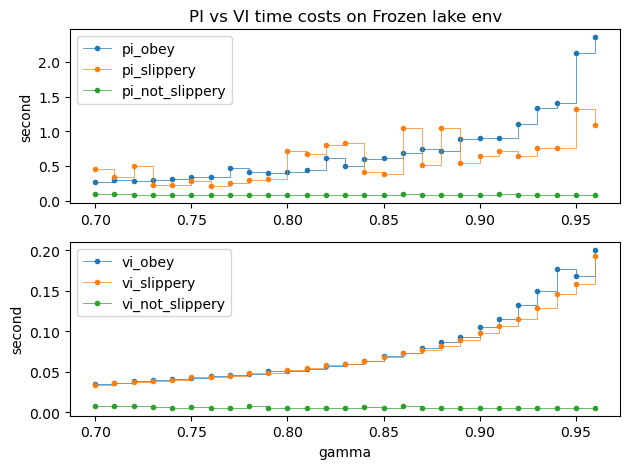

In [229]:
max_idx = 27
pi_obey = result_dict_pi_gamma_iter_fl_10_high_obey['time_used_list'][0:max_idx]
pi_slippery = result_dict_pi_gamma_iter_fl_10_slippery['time_used_list'][0:max_idx]
pi_not_slippery = result_dict_pi_gamma_iter_fl_10_not_slippery['time_used_list'][0:max_idx]

vi_obey = result_dict_vi_gamma_iter_fl_10_high_obey['time_used_list'][0:max_idx]
vi_slippery = result_dict_vi_gamma_iter_fl_10_slippery['time_used_list'][0:max_idx]
vi_not_slippery = result_dict_vi_gamma_iter_fl_10_not_slippery['time_used_list'][0:max_idx]

gamma_ls = result_dict_pi_gamma_iter_fl_10_high_obey['gamma_list'][0:max_idx]

fig, ax = plt.subplots(2, 1)

ax[0].plot(gamma_ls, pi_obey, marker="o", drawstyle="steps-post", label ='pi_obey', markersize = 3,linewidth=0.5)
ax[0].plot(gamma_ls, pi_slippery, marker="o", drawstyle="steps-post", label ='pi_slippery', markersize = 3,linewidth=0.5)
ax[0].plot(gamma_ls, pi_not_slippery, marker="o", drawstyle="steps-post", label ='pi_not_slippery', markersize = 3,linewidth=0.5)
# ax[0].set_xlabel("gamma")
ax[0].set_ylabel("second")
ax[0].legend()
ax[0].set_title('PI vs VI time costs on Frozen lake env')

ax[1].plot(gamma_ls, vi_obey, marker="o", drawstyle="steps-post", label ='vi_obey', markersize = 3,linewidth=0.5)
ax[1].plot(gamma_ls, vi_slippery, marker="o", drawstyle="steps-post", label ='vi_slippery', markersize = 3,linewidth=0.5)
ax[1].plot(gamma_ls, vi_not_slippery, marker="o", drawstyle="steps-post", label ='vi_not_slippery', markersize = 3,linewidth=0.5)
ax[1].set_xlabel("gamma")
ax[1].set_ylabel("second")
ax[1].legend()
fig.tight_layout()

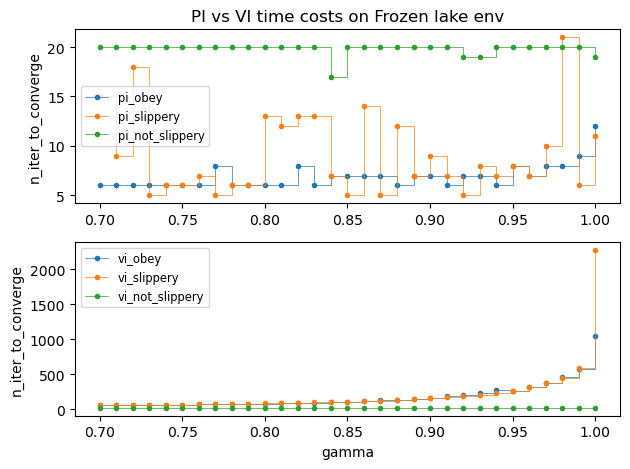

In [221]:
pi_obey = result_dict_pi_gamma_iter_fl_10_high_obey['n_iter_converged_list']
pi_slippery = result_dict_pi_gamma_iter_fl_10_slippery['n_iter_converged_list']
pi_not_slippery = result_dict_pi_gamma_iter_fl_10_not_slippery['n_iter_converged_list']

vi_obey = result_dict_vi_gamma_iter_fl_10_high_obey['n_iter_converged_list']
vi_slippery = result_dict_vi_gamma_iter_fl_10_slippery['n_iter_converged_list']
vi_not_slippery = result_dict_vi_gamma_iter_fl_10_not_slippery['n_iter_converged_list']

gamma_ls = result_dict_pi_gamma_iter_fl_10_high_obey['gamma_list']

fig, ax = plt.subplots(2, 1)

ax[0].plot(gamma_ls, pi_obey, marker="o", drawstyle="steps-post", label ='pi_obey', markersize = 3,linewidth=0.5)
ax[0].plot(gamma_ls, pi_slippery, marker="o", drawstyle="steps-post", label ='pi_slippery', markersize = 3,linewidth=0.5)
ax[0].plot(gamma_ls, pi_not_slippery, marker="o", drawstyle="steps-post", label ='pi_not_slippery', markersize = 3,linewidth=0.5)
# ax[0].set_xlabel("gamma")
ax[0].set_ylabel("n_iter_to_converge")
ax[0].legend(fontsize="small")
ax[0].set_title('PI vs VI time costs on Frozen lake env')

ax[1].plot(gamma_ls, vi_obey, marker="o", drawstyle="steps-post", label ='vi_obey', markersize = 3,linewidth=0.5)
ax[1].plot(gamma_ls, vi_slippery, marker="o", drawstyle="steps-post", label ='vi_slippery', markersize = 3,linewidth=0.5)
ax[1].plot(gamma_ls, vi_not_slippery, marker="o", drawstyle="steps-post", label ='vi_not_slippery', markersize = 3,linewidth=0.5)
ax[1].set_xlabel("gamma")
ax[1].set_ylabel("n_iter_to_converge")
ax[1].legend(fontsize="small")
fig.tight_layout()

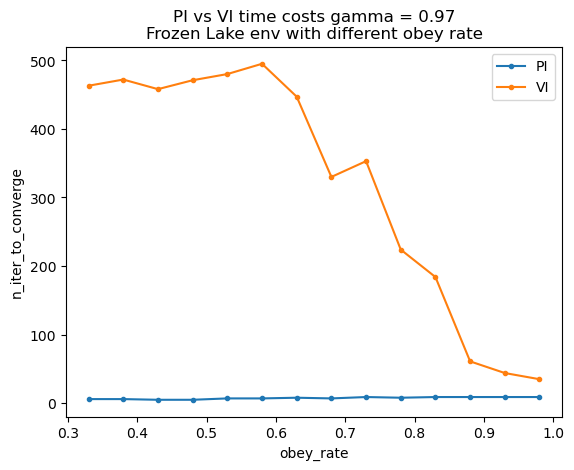

In [238]:
pi_obey_iter = result_dict_iter_fl_obey_rate['pi_n_iter_converged_list']

vi_taxi_iter = result_dict_iter_fl_obey_rate['vi_n_iter_converged_list']

obey_ls = result_dict_iter_fl_obey_rate['obey_rate_list']

plt.plot(obey_ls, pi_obey_iter, label = 'PI',marker='o', markersize = 3)
plt.plot(obey_ls, vi_taxi_iter, label = 'VI',marker='o', markersize = 3)
plt.xlabel('obey_rate')
plt.ylabel('n_iter_to_converge')
plt.title('PI vs VI n_iter_to_converge gamma = 0.97\nFrozen Lake env with different obey rate')
plt.legend()

plt.show()

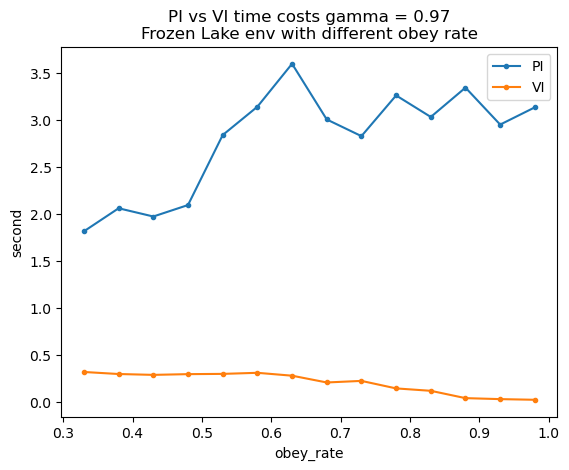

In [206]:
pi_obey_iter = result_dict_iter_fl_obey_rate['pi_time_used_list']

vi_taxi_iter = result_dict_iter_fl_obey_rate['vi_time_used_list']

obey_ls = result_dict_iter_fl_obey_rate['obey_rate_list']

plt.plot(obey_ls, pi_obey_iter, label = 'PI',marker='o', markersize = 3)
plt.plot(obey_ls, vi_taxi_iter, label = 'VI',marker='o', markersize = 3)
plt.xlabel('obey_rate')
plt.ylabel('second')
plt.title('PI vs VI time costs gamma = 0.97\nFrozen Lake env with different obey rate')
plt.legend()

plt.show()

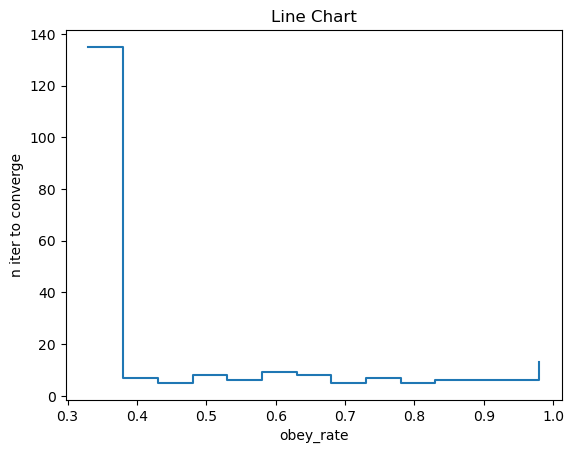

In [41]:
x = result_dict_iter_fl_obey_rate['obey_rate_list']
y = result_dict_iter_fl_obey_rate['pi_n_iter_converged_list']

plt.plot(x, y, drawstyle='steps-post')
plt.xlabel('obey_rate')
plt.ylabel('n iter to converge')
plt.title('Line Chart')
plt.show()

## Taxi - Value iteration

In [18]:
result_dict_vi_gamma_iter_taxi_not_slippery = iter_gamma_on_MDP_iteration(env_taxi, algorithm = 'value',gamma_lower = 0.7)



runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.05 seconds
runtime = 0.05 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds


## Taxi - Policy iteration

In [19]:
result_dict_pi_gamma_iter_taxi_not_slippery = iter_gamma_on_MDP_iteration(env_taxi, algorithm = 'value',gamma_lower = 0.7)



runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds
runtime = 0.04 seconds


## Taxi Analysis

### time cost

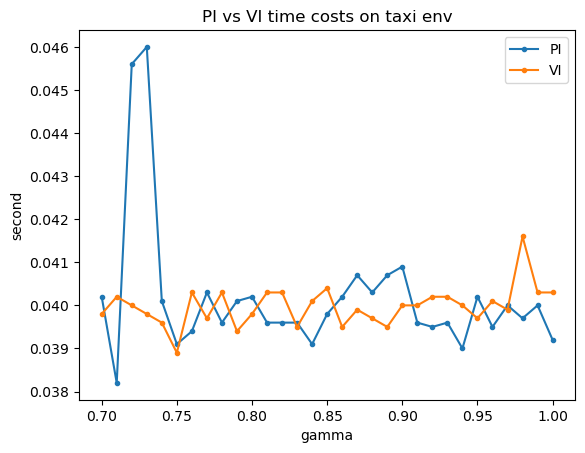

In [203]:
pi_taxi = result_dict_vi_gamma_iter_taxi_not_slippery['time_used_list']

vi_taxi = result_dict_pi_gamma_iter_taxi_not_slippery['time_used_list']

gamma_ls = result_dict_pi_gamma_iter_taxi_not_slippery['gamma_list']

plt.plot(gamma_ls, pi_taxi, label = 'PI',marker='o', markersize = 3)
plt.plot(gamma_ls, vi_taxi, label = 'VI',marker='o', markersize = 3)
plt.xlabel('gamma')
plt.ylabel('second')
plt.title('PI vs VI time costs on taxi env')
plt.legend()

plt.show()

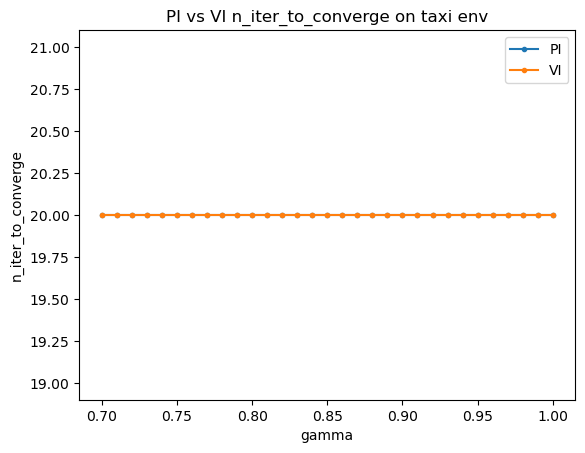

In [236]:
pi_taxi = result_dict_pi_gamma_iter_taxi_not_slippery['n_iter_converged_list']

vi_taxi = result_dict_vi_gamma_iter_taxi_not_slippery['n_iter_converged_list']

gamma_ls = result_dict_pi_gamma_iter_taxi_not_slippery['gamma_list']

plt.plot(gamma_ls, pi_taxi, label = 'PI',marker='o', markersize = 3)
plt.plot(gamma_ls, vi_taxi, label = 'VI',marker='o', markersize = 3)
plt.xlabel('gamma')
plt.ylabel('n_iter_to_converge')
plt.title('PI vs VI n_iter_to_converge on taxi env')
plt.legend()

plt.show()

### test score

In [ ]:
test_scores_ql_taxi = test_policy(result_dict_vi_gamma_iter_taxi_not_slippery['pi_list'][-1], env_taxi ,n_test = 1000,goal_reward=20,sleep_bt_step=0.1,show_game=True)
test_scores_ql_taxi['total_reward']

s: 238 a: 3
Episode: 405, Total reward: -798
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)



# Run games on Q learning

## Grid world - Q learning

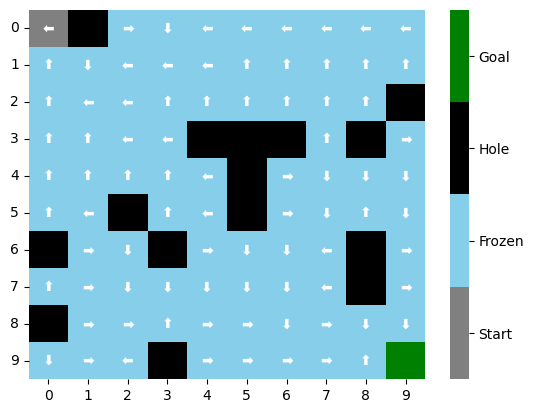

pi has not changed after 51 tracking step, considered as converged


In [20]:
n_iter = 100000
env = env_fl_10_high_obey
q_agent_fl_10_high_obey = QAgent(env)
track_step = 10
goal_reward = 1

result_dict_ql_fl_high_obey = q_learning_fit(q_agent_fl_10_high_obey, env, n_iter = n_iter, converge_criteria=50, goal_reward = 1)

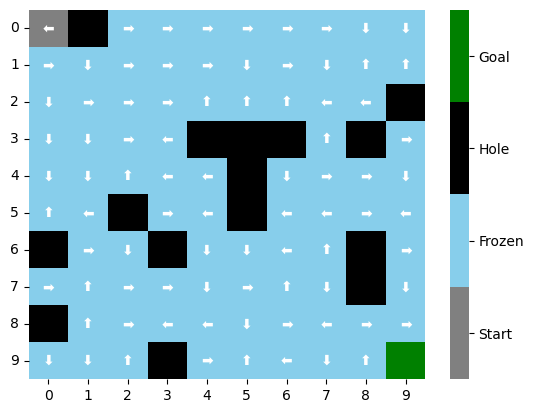

pi has not changed after 51 tracking step, considered as converged


In [21]:
# iter on eps_decay_rate
n_iter = 10000
n_test = 200
env = env_fl_10_high_obey
lower_b = 1
upper_b = 10
converge_criteria = 50
result_dict_iter_eps_fl_high_obey = ql_iter_on_eps_decay_rate(env, converge_criteria = converge_criteria, n_iter=n_iter, n_test = n_test, lower_b = 1, upper_b = upper_b)

In [22]:
test_scores_ql_fl_high_obey = test_policy(q_agent_fl_10_high_obey.get_action, env_fl_10_high_obey ,
                                          n_test = 1000,sleep_bt_step=0.1,show_game=False,goal_reward = 2)

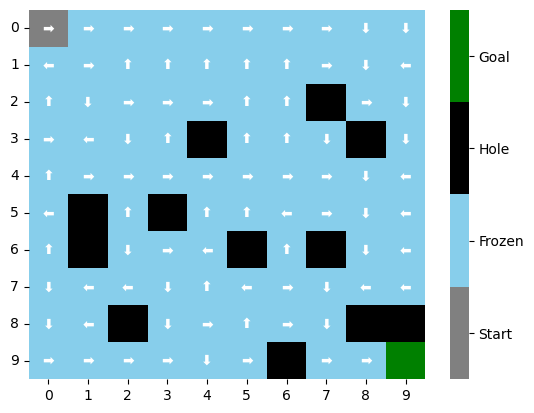

pi has not changed after 31 tracking step, considered as converged


In [23]:
n_iter = 100000
env = env_fl_10_not_slippery
q_agent_fl_10_not_slippery = QAgent(env)
track_step = 10
goal_reward = 1

result_dict_ql_fl_not_slippery = q_learning_fit(q_agent_fl_10_not_slippery, env, n_iter = n_iter, converge_criteria=30)

In [31]:
test_scores_ql_fl_not_slippery = test_policy(q_agent_fl_10_not_slippery.get_action, env_fl_10_not_slippery ,n_test = 1000,sleep_bt_step=0.1, show_game=False)
test_scores_ql_fl_not_slippery['total_reward']

929.0

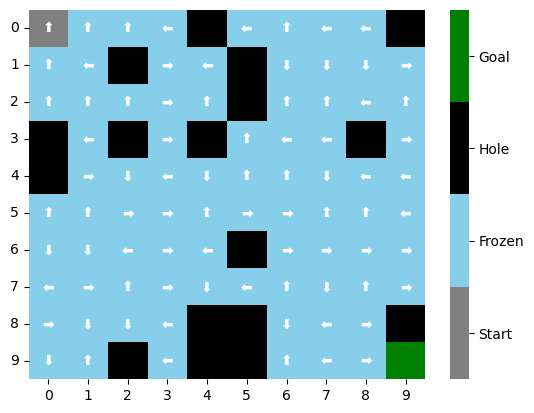

pi has not changed after 51 tracking step, considered as converged


In [25]:
n_iter = 100000
env = env_fl_10_slippery
q_agent_fl_10_slippery = QAgent(env, eps_decay_rate = 1e-7)
track_step = 10
goal_reward = 1

result_dict_ql_fl_slippery = q_learning_fit(q_agent_fl_10_slippery, env, n_iter = n_iter, converge_criteria=50)


In [26]:
# iter on eps_decay_rate
n_iter = 100000
n_test = 100
env = env_fl_10_slippery
lower_b = 1
upper_b = 10
converge_criteria = 50
result_dict_iter_eps_fl_slippery = ql_iter_on_eps_decay_rate(env, converge_criteria = converge_criteria, n_iter=n_iter, n_test = n_test, lower_b = 1, upper_b = upper_b)


Episode: 10000, Total reward: 0.0, eps: 0.9999990000004111
pi has not changed after 1 tracking step


In [27]:
test_scores_ql_fl_slippery = test_policy(q_agent_fl_10_slippery.get_action, env_fl_10_slippery ,n_test = 1000,sleep_bt_step=0.1, show_game=False)

test_scores_ql_fl_slippery['total_reward']

0.0

## Taxi - Q learning

In [28]:
n_iter = 100000
env = env_taxi
q_agent_taxi = QAgent(env)
track_step = 10
goal_reward = 20

result_dict_ql_taxi = q_learning_fit(q_agent_taxi, env, n_iter = n_iter, converge_criteria=100,goal_reward=goal_reward)


pi has not changed after 101 tracking step, considered as converged


In [ ]:
test_scores_ql_taxi = test_policy(q_agent_taxi.get_action, env_taxi ,n_test = 1000,goal_reward=20,sleep_bt_step=0.1,show_game=True)
test_scores_ql_taxi['total_reward']


s: 18 a: 4
Episode: 287, Total reward: 1881
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)



In [35]:
# out of 1001 test, the goal was reached 1001 times, QL learned the best policy
len(test_scores_ql_taxi['iter_reaching_goal'])

1001

In [245]:
# iter on eps_decay_rate
n_iter = 100000
n_test = 100
env = env_taxi
lower_b = 1
upper_b = 7
converge_criteria = 50
result_dict_iter_eps_taxi_slippery = ql_iter_on_eps_decay_rate(env, converge_criteria = converge_criteria, n_iter=n_iter, n_test = n_test, lower_b = 1, upper_b = upper_b)


KeyboardInterrupt: 